<a href="https://colab.research.google.com/github/naemililia/masterthesis/blob/main/Baseline_Sen1floods11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on the Train.ipynb from the Sen1floods11 dataset authors (GitHub: https://github.com/cloudtostreet/Sen1Floods11)

It is used to train the semantic segmentation baseline model, using the hand labeled Sen1floods11 dataset.

Note that to run this code, you must connect your notebook runtime to a GPU.

Install RasterIO

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 75.7 MB/s eta 0:00:00


Define a model checkpoint folder, for storing network checkpoints during training

In [ ]:
%cd /home
!sudo mkdir checkpoints

/home


Download train, test, and validation splits for both flood water.

In [ ]:
!gsutil cp gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_train_data.csv .
!gsutil cp gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_test_data.csv .
!gsutil cp gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_valid_data.csv .

Copying gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_train_data.csv...
/ [1 files][ 13.3 KiB/ 13.3 KiB]                                                
Operation completed over 1 objects/13.3 KiB.                                     
Copying gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_test_data.csv...
/ [1 files][  4.7 KiB/  4.7 KiB]                                                
Operation completed over 1 objects/4.7 KiB.                                      
Copying gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_valid_data.csv...
/ [1 files][  4.7 KiB/  4.7 KiB]                                                
Operation completed over 1 objects/4.7 KiB.                                      


Download raw train, test, and validation data.

In [ ]:
!sudo mkdir files
!sudo mkdir files/S1
!sudo mkdir files/Labels

!gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand files/S1
!gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand files/Labels


both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

Building synchronization state...
Starting synchronization...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/Ghana_187318_S1Hand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/Bolivia_103757_S1Hand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/Ghana_24858_S1Hand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/Ghana_11745_S1Hand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/Bolivia_379434_S1Hand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/Bolivia_233925_S1Hand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLab

Define model training hyperparameters

In [ ]:
LR = 5e-4
RUNNAME = "Sen1Floods11-Base-resnet18"

Define functions to process and augment training and testing images

In [ ]:
import torch
from torchvision import transforms
import torchvision.transforms.functional as F
import random
from PIL import Image

class InMemoryDataset(torch.utils.data.Dataset):

  def __init__(self, data_list, preprocess_func):
    self.data_list = data_list
    self.preprocess_func = preprocess_func

  def __getitem__(self, i):
    return self.preprocess_func(self.data_list[i])

  def __len__(self):
    return len(self.data_list)


def processAndAugment(data):
  """
  Process and augment the training data.
  - random cropping
  - random horizontal + vertical flipping
  - normalisation
  """
  (x,y) = data
  im,label = x.copy(), y.copy()

  # convert to PIL for easier transforms
  im1 = Image.fromarray(im[0])
  im2 = Image.fromarray(im[1])
  label = Image.fromarray(label.squeeze())

  # Get params for random transforms
  i, j, h, w = transforms.RandomCrop.get_params(im1, (256, 256))

  im1 = F.crop(im1, i, j, h, w)
  im2 = F.crop(im2, i, j, h, w)
  label = F.crop(label, i, j, h, w)
  if random.random() > 0.5:
    im1 = F.hflip(im1)
    im2 = F.hflip(im2)
    label = F.hflip(label)
  if random.random() > 0.5:
    im1 = F.vflip(im1)
    im2 = F.vflip(im2)
    label = F.vflip(label)


  norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102]) # these values come from the authors themselves
  im = torch.stack([transforms.ToTensor()(im1).squeeze(), transforms.ToTensor()(im2).squeeze()])
  im = norm(im)
  label = transforms.ToTensor()(label).squeeze()
  if torch.sum(label.gt(.003) * label.lt(.004)):
    label *= 255
  label = label.round()

  return im, label


def processTestIm(data):
  """
  Process and Augment validation and test data.
  - no random cropping, but sectioning the image into 4 rectangles.
  - no random flipping
  - normalisation
  """
  (x,y) = data
  im,label = x.copy(), y.copy()
  norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])

  # convert to PIL for easier transforms
  im_c1 = Image.fromarray(im[0]).resize((512,512))
  im_c2 = Image.fromarray(im[1]).resize((512,512))
  label = Image.fromarray(label.squeeze()).resize((512,512))

  im_c1s = [F.crop(im_c1, 0, 0, 256, 256), F.crop(im_c1, 0, 256, 256, 256),
            F.crop(im_c1, 256, 0, 256, 256), F.crop(im_c1, 256, 256, 256, 256)]
  im_c2s = [F.crop(im_c2, 0, 0, 256, 256), F.crop(im_c2, 0, 256, 256, 256),
            F.crop(im_c2, 256, 0, 256, 256), F.crop(im_c2, 256, 256, 256, 256)]
  labels = [F.crop(label, 0, 0, 256, 256), F.crop(label, 0, 256, 256, 256),
            F.crop(label, 256, 0, 256, 256), F.crop(label, 256, 256, 256, 256)]

  ims = [torch.stack((transforms.ToTensor()(x).squeeze(),
                    transforms.ToTensor()(y).squeeze()))
                    for (x,y) in zip(im_c1s, im_c2s)]

  ims = [norm(im) for im in ims]
  ims = torch.stack(ims)

  labels = [(transforms.ToTensor()(label).squeeze()) for label in labels]
  labels = torch.stack(labels)

  if torch.sum(labels.gt(.003) * labels.lt(.004)):
    labels *= 255
  labels = labels.round()

  return ims, labels

Load train, test, and validation data from the splits csv's.

In [ ]:
from time import time
import csv
import os
import numpy as np
import rasterio

def getArrFlood(fname):
  return rasterio.open(fname).read()

def download_flood_water_data_from_list(l):
  """
  Creates a list of tuples where the first entry is the clipped array of the image,
  and second entry is the array of the label, where -1 values (undefined / no value) are transformed to 255s.

  l: list created from load_flood_train_data or equivalent
  """
  i = 0
  tot_nan = 0
  tot_good = 0
  flood_data = []
  for (im_fname, mask_fname) in l:
    if not os.path.exists(os.path.join("files/", im_fname)):
      continue
    arr_x = np.nan_to_num(getArrFlood(os.path.join("files/", im_fname)))
    arr_y = getArrFlood(os.path.join("files/", mask_fname))
    arr_y[arr_y == -1] = 255

    arr_x = np.clip(arr_x, -50, 1) # see the Sen1floods data pre-processing section in the thesis to understand why these values are chosen
    arr_x = (arr_x + 50) / 51

    # every 100 images print the image and label name, as a sort of tracking
    if i % 100 == 0:
      print(im_fname, mask_fname)
    i += 1
    flood_data.append((arr_x,arr_y))

  return flood_data

def load_flood_train_data(input_root, label_root):
  """
  Creates a list of tuples of the paths to both the image and the label.
  Passes this list to the download_flood_water_data_from_list function and returns the return value.

  input_root: path to input images
  label_root: path to labels
  """
  fname = "flood_train_data.csv"
  training_files = []
  with open(fname) as f:
    for line in csv.reader(f):
      training_files.append(tuple((input_root+line[0], label_root+line[1])))

  return download_flood_water_data_from_list(training_files)

def load_flood_valid_data(input_root, label_root):
  fname = "flood_valid_data.csv"
  validation_files = []
  with open(fname) as f:
    for line in csv.reader(f):
      validation_files.append(tuple((input_root+line[0], label_root+line[1])))

  return download_flood_water_data_from_list(validation_files)

def load_flood_test_data(input_root, label_root):
  fname = "flood_test_data.csv"
  testing_files = []
  with open(fname) as f:
    for line in csv.reader(f):
      testing_files.append(tuple((input_root+line[0], label_root+line[1])))

  return download_flood_water_data_from_list(testing_files)

Load training data and validation data.

the batches of images in the train_loader will be of shape [16,2,256,256] as we have 16 images (and labels) per batch, and each image has 2 channels and is of size 256 x 256

In [ ]:
train_data = load_flood_train_data('S1/', 'Labels/')
train_dataset = InMemoryDataset(train_data, processAndAugment)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=None,
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
train_iter = iter(train_loader)

valid_data = load_flood_valid_data('S1/', 'Labels/')
valid_dataset = InMemoryDataset(valid_data, processTestIm)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=lambda x: (torch.cat([a[0] for a in x], 0), torch.cat([a[1] for a in x], 0)),
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
valid_iter = iter(valid_loader)

S1/Ghana_103272_S1Hand.tif Labels/Ghana_103272_LabelHand.tif
S1/Pakistan_132143_S1Hand.tif Labels/Pakistan_132143_LabelHand.tif
S1/Sri-Lanka_916628_S1Hand.tif Labels/Sri-Lanka_916628_LabelHand.tif
S1/Ghana_5079_S1Hand.tif Labels/Ghana_5079_LabelHand.tif


In [ ]:
test_data = load_flood_test_data('S1/', 'Labels/')
test_dataset = InMemoryDataset(test_data, processTestIm)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=lambda x: (torch.cat([a[0] for a in x], 0), torch.cat([a[1] for a in x], 0)),
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
test_iter = iter(test_loader)

S1/Ghana_313799_S1Hand.tif Labels/Ghana_313799_LabelHand.tif


Define the network.

In [ ]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 787.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
import segmentation_models_pytorch as smp

net = smp.Unet(encoder_name = 'resnet18', encoder_weights=None, in_channels=2, classes = 2) # 2 input channels from SAR image, and 2 output channels (water / no water)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([1,8]).float().cuda(), ignore_index=255)
optimizer = torch.optim.AdamW(net.parameters(),lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, len(train_loader) * 10, T_mult=2, eta_min=0, last_epoch=-1)

# len(train_loader) equals the number of batches we have, this sets the number of iterations for the first restart. it takes len(train_loader) amount of batches to complete one epoch. Therefore, the first restart happens after 10 epochs
# T_mult = 2: this means that after each restart, the number of epochs will double until the next restart, i.e. in our case: 10 epochs, then 20, then 40, then 80 etc

def convertBNtoGN(module, num_groups=16):
  """
  this was included from senfloods creators.
  possible explanation:
    GroupNorm was introduced as an alternative to BatchNorm, especially beneficial for cases where the batch size is small (in our case: 16).
    GroupNorm divides the channels into groups and computes the mean and standard deviation within these groups for normalization.
  """
  if isinstance(module, torch.nn.modules.batchnorm.BatchNorm2d):
    return nn.GroupNorm(num_groups, module.num_features,
                        eps=module.eps, affine=module.affine)
    if module.affine:
        mod.weight.data = module.weight.data.clone().detach()
        mod.bias.data = module.bias.data.clone().detach()

  for name, child in module.named_children():
      module.add_module(name, convertBNtoGN(child, num_groups=num_groups))

  return module

net = convertBNtoGN(net)

In [ ]:
net

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): GroupNorm(16, 64, eps=1e-05, affine=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): GroupNorm(16, 64, eps=1e-05, affine=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): GroupNorm(16, 64, eps=1e-05, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): GroupNorm(16, 64, eps=1e-05, affine=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

Define assessment metrics.

In [ ]:
def computeIOU(output, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()

  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  intersection = torch.sum(output * target)
  union = torch.sum(target) + torch.sum(output) - intersection
  iou = (intersection + .0000001) / (union + .0000001)

  if iou != iou:
    print("failed, replacing with 0")
    iou = torch.tensor(0).float()

  return iou

def computeAccuracy(output, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()

  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  correct = torch.sum(output.eq(target))

  return correct.float() / len(target)

def truePositives(output, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  correct = torch.sum(output * target)

  return correct

def trueNegatives(output, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  output = (output == 0)
  target = (target == 0)
  correct = torch.sum(output * target)

  return correct

def falsePositives(output, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  output = (output == 1)
  target = (target == 0)
  correct = torch.sum(output * target)

  return correct

def falseNegatives(output, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  output = (output == 0)
  target = (target == 1)
  correct = torch.sum(output * target)

  return correct

Define training loop

In [ ]:
training_losses = []
training_accuracies = []
training_ious = []

def train_loop(inputs, labels, net, optimizer, scheduler):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy

  # zero the parameter gradients
  optimizer.zero_grad()
  net = net.cuda()

  # forward + backward + optimize
  outputs = net(inputs.cuda())
  #loss = criterion(outputs["out"], labels.long().cuda())
  loss = criterion(outputs, labels.long().cuda())
  loss.backward()
  optimizer.step()
  scheduler.step()

  running_loss += loss
  #running_iou += computeIOU(outputs["out"], labels.cuda())
  #running_accuracy += computeAccuracy(outputs["out"], labels.cuda())
  running_iou += computeIOU(outputs, labels.cuda())
  running_accuracy += computeAccuracy(outputs, labels.cuda())
  running_count += 1

Define validation loop

In [ ]:
valid_losses = []
valid_accuracies = []
valid_ious = []

def validation_loop(validation_data_loader, net):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  global max_valid_iou

  global training_losses
  global training_accuracies
  global training_ious
  global valid_losses
  global valid_accuracies
  global valid_ious

  net = net.eval()
  net = net.cuda()
  count = 0
  iou = 0
  loss = 0
  accuracy = 0
  with torch.no_grad():
      for (images, labels) in validation_data_loader:
          net = net.cuda()
          outputs = net(images.cuda())
          #valid_loss = criterion(outputs["out"], labels.long().cuda())
          #valid_iou = computeIOU(outputs["out"], labels.cuda())
          #valid_accuracy = computeAccuracy(outputs["out"], labels.cuda())
          valid_loss = criterion(outputs, labels.long().cuda())
          valid_iou = computeIOU(outputs, labels.cuda())
          valid_accuracy = computeAccuracy(outputs, labels.cuda())
          iou += valid_iou
          loss += valid_loss
          accuracy += valid_accuracy
          count += 1

  iou = iou / count
  accuracy = accuracy / count

  if iou > max_valid_iou:
    max_valid_iou = iou
    # save it to my drive (i mount it below) --> actually dont, because it takes too much storage! (124 MB per checkpoint)
    #save_base_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/baseline_senfloods/'
    save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
    #save_path = save_base_path + '{}_{}_{}.cp'.format(RUNNAME, i, iou.item())
    torch.save(net.state_dict(), save_path)
    print("model saved at", save_path)

  loss = loss / count
  print("Training Loss:", running_loss / running_count)
  print("Training IOU:", running_iou / running_count)
  print("Training Accuracy:", running_accuracy / running_count)
  print("Validation Loss:", loss)
  print("Validation IOU:", iou)
  print("Validation Accuracy:", accuracy)


  training_losses.append(running_loss / running_count)
  training_accuracies.append(running_accuracy / running_count)
  training_ious.append(running_iou / running_count)
  valid_losses.append(loss)
  valid_accuracies.append(accuracy)
  valid_ious.append(iou)

Define testing loop (here, you can replace assessment metrics).

In [ ]:
def test_loop(test_data_loader, net):
  net = net.eval()
  net = net.cuda()
  count = 0
  iou = 0
  loss = 0
  accuracy = 0
  with torch.no_grad():
      for (images, labels) in tqdm(test_data_loader):
          net = net.cuda()
          outputs = net(images.cuda())
          #valid_loss = criterion(outputs["out"], labels.long().cuda()) # keeping these for adaptations with UNet
          #valid_iou = computeIOU(outputs["out"], labels.cuda())
          valid_loss = criterion(outputs, labels.long().cuda())
          valid_iou = computeIOU(outputs, labels.cuda())
          iou += valid_iou
          accuracy += computeAccuracy(outputs, labels.cuda()) # originally there also was a outputs["out"] here instead of just outputs
          count += 1

  iou = iou / count
  print("Test IOU:", iou)
  print("Test Accuracy:", accuracy / count)

Define training and validation scheme

In [ ]:
from tqdm.notebook import tqdm
from IPython.display import clear_output

running_loss = 0
running_iou = 0
running_count = 0
running_accuracy = 0

training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []


def train_epoch(net, optimizer, scheduler, train_iter):
  for (inputs, labels) in tqdm(train_iter):
    train_loop(inputs.cuda(), labels.cuda(), net.cuda(), optimizer, scheduler)


def train_validation_loop(net, optimizer, scheduler, train_loader,
                          valid_loader, num_epochs, cur_epoch):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  net = net.train()
  running_loss = 0
  running_iou = 0
  running_count = 0
  running_accuracy = 0

  for i in tqdm(range(num_epochs)):
    train_iter = iter(train_loader)
    train_epoch(net, optimizer, scheduler, train_iter)
  clear_output()

  print("Current Epoch:", cur_epoch)
  validation_loop(iter(valid_loader), net)

In [ ]:
# save the model to my drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Train model and assess metrics over epochs

Current Epoch: 53
Training Loss: tensor(0.1596, device='cuda:0', grad_fn=<DivBackward0>)
Training IOU: tensor(0.5868, device='cuda:0')
Training Accuracy: tensor(0.9437, device='cuda:0')
Validation Loss: tensor(0.2410, device='cuda:0')
Validation IOU: tensor(0.5051, device='cuda:0')
Validation Accuracy: tensor(0.9286, device='cuda:0')


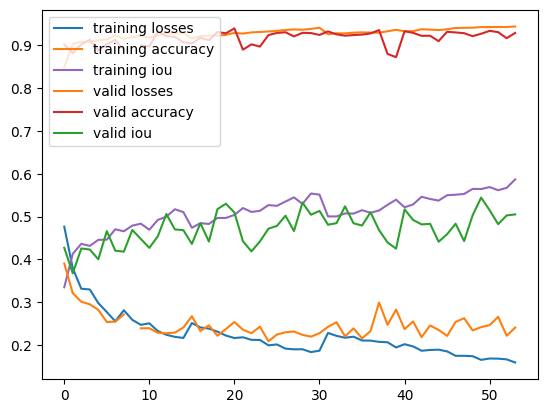

None

max valid iou: tensor(0.5443, device='cuda:0')


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import os
from IPython.display import display
import matplotlib.pyplot as plt

max_valid_iou = 0
start = 0

epochs = []
training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []

for i in range(start, 100):
  train_validation_loop(net, optimizer, scheduler, train_loader, valid_loader, 10, i)
  epochs.append(i)
  x = epochs
  if i % 10 == 0:
    save_base_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/baseline_senfloods/'
    #save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
    save_path = save_base_path + '{}_{}_{}.cp'.format(RUNNAME, i, max_valid_iou.item())
    torch.save(net.state_dict(), save_path)

    # Ensure data for plotting is on CPU and in numpy format
  training_losses_np = [loss.item() for loss in training_losses]  # Assuming losses are tensors
  training_accuracies_np = [acc.item() for acc in training_accuracies]  # Same assumption
  training_ious_np = [iou.item() for iou in training_ious]
  valid_losses_np = [loss.item() for loss in valid_losses]
  valid_accuracies_np = [acc.item() for acc in valid_accuracies]
  valid_ious_np = [iou.item() for iou in valid_ious]

  plt.plot(x, training_losses_np, label='training losses')
  plt.plot(x, training_accuracies_np, 'tab:orange', label='training accuracy')
  plt.plot(x, training_ious_np, 'tab:purple', label='training iou')
  plt.plot(x, valid_losses_np, label='valid losses')
  plt.plot(x, valid_accuracies_np, 'tab:red', label='valid accuracy')
  plt.plot(x, valid_ious_np, 'tab:green', label='valid iou')
  plt.legend(loc="upper left")
  #plt.show()  # Optionally, show plot after updating each time

  # plt.plot(x, training_losses, label='training losses')
  # plt.plot(x, training_accuracies, 'tab:orange', label='training accuracy')
  # plt.plot(x, training_ious, 'tab:purple', label='training iou')
  # plt.plot(x, valid_losses, label='valid losses')
  # plt.plot(x, valid_accuracies, 'tab:red',label='valid accuracy')
  # plt.plot(x, valid_ious, 'tab:green',label='valid iou')
  # plt.legend(loc="upper left")

  display(plt.show())

  print("max valid iou:", max_valid_iou)

# save the model at the end as well, the one with highest iou
save_base_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/baseline_senfloods/'
save_path = save_base_path + '{}_{}_{}.cp'.format(RUNNAME, 100, max_valid_iou.item())
torch.save(net.state_dict(), save_path)

Save the trained model to my drive

In [ ]:
# this is to save
model_save_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/baseline_senfloods/test_unet_5_epochs.pth'
torch.save(net.state_dict(), model_save_path)


In [ ]:
# this is to retrieve
model_save_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/baseline_senfloods/'
checkpoints = os.listdir(model_save_path)
checkpoints
state_dict = torch.load(model_save_path + 'test_unet_5_epochs.pthSen1Floods11_1_0.4269200563430786.cp')

In [ ]:
net.load_state_dict(state_dict)

<All keys matched successfully>

Test the model on the test data

In [ ]:
test_loop(test_loader, net)

  0%|          | 0/23 [00:00<?, ?it/s]

Test IOU: tensor(0.4731, device='cuda:0')
Test Accuracy: tensor(0.9165, device='cuda:0')


  0%|          | 0/23 [00:00<?, ?it/s]

(256, 256)


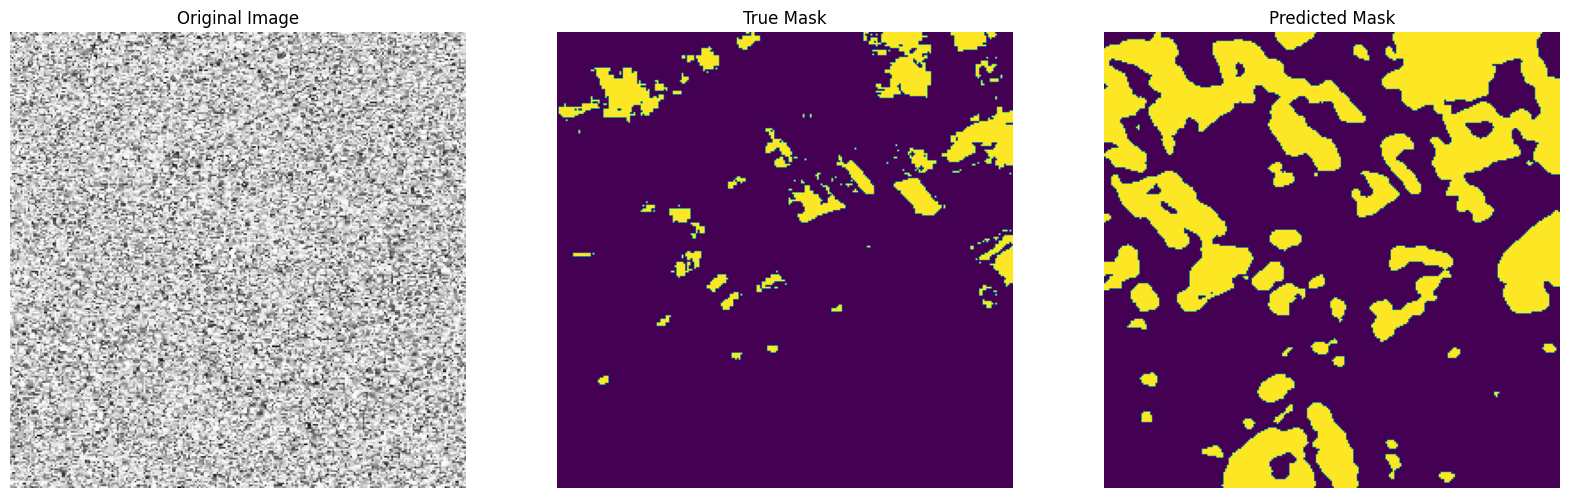

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm

def visualize_segmentation_example(net, test_data_loader):
    net.eval()  # Ensure the model is in evaluation mode.
    net.cuda()  # Ensure the model operates on the GPU.

    with torch.no_grad():  # Disable gradient computation for efficiency.
        # Iterating over the test dataset to get a single batch.
        for images, labels in tqdm(test_data_loader):
            images, labels = images.cuda(), labels.cuda()

            # Obtain the model's predictions.
            outputs = net(images)
            # Assuming the outputs are raw logits, apply softmax to obtain probabilities.
            probs = torch.softmax(outputs, dim=1)
            # Convert probabilities to predicted class labels.
            predicted_masks = torch.argmax(probs, dim=1)

            # Move the tensors to the CPU for visualization.
            images, labels, predicted_masks = images.cpu(), labels.cpu(), predicted_masks.cpu()

            # Convert the first image and masks to PIL images for easy visualization.
            original_image = to_pil_image(images[0])
            true_mask = to_pil_image(labels[0].unsqueeze(0).float())  # Adding channel dimension for compatibility.
            predicted_mask = to_pil_image(predicted_masks[0].unsqueeze(0).byte())
            print(predicted_mask.size)

            # Visualization
            fig, ax = plt.subplots(1, 3, figsize=(20, 10))
            ax[0].imshow(original_image)
            ax[0].set_title('Original Image')
            ax[0].axis('off')

            ax[1].imshow(true_mask, )
            ax[1].set_title('True Mask')
            ax[1].axis('off')

            ax[2].imshow(predicted_mask, )
            ax[2].set_title('Predicted Mask')
            ax[2].axis('off')

            plt.show()

            # Break after the first batch to only visualize one example.
            break

# Assuming net and test_data_loader are already defined and initialized.
visualize_segmentation_example(net, test_loader)


In [ ]:
valid_ious

[tensor(0.4508, device='cuda:0'),
 tensor(0.4760, device='cuda:0'),
 tensor(0.3888, device='cuda:0'),
 tensor(0.4871, device='cuda:0'),
 tensor(0.4304, device='cuda:0'),
 tensor(0.4523, device='cuda:0'),
 tensor(0.4939, device='cuda:0'),
 tensor(0.5087, device='cuda:0'),
 tensor(0.4789, device='cuda:0'),
 tensor(0.4574, device='cuda:0'),
 tensor(0.4945, device='cuda:0'),
 tensor(0.4266, device='cuda:0'),
 tensor(0.4428, device='cuda:0'),
 tensor(0.4742, device='cuda:0'),
 tensor(0.5042, device='cuda:0'),
 tensor(0.4846, device='cuda:0'),
 tensor(0.4699, device='cuda:0'),
 tensor(0.5186, device='cuda:0'),
 tensor(0.4680, device='cuda:0'),
 tensor(0.4706, device='cuda:0')]

In [ ]:
valid_ious_np

[0.4508248269557953,
 0.47601985931396484,
 0.3887999951839447,
 0.48713091015815735,
 0.4303686320781708,
 0.4523465931415558,
 0.4938982427120209,
 0.5086847543716431,
 0.4788782298564911,
 0.4574028253555298,
 0.49445146322250366,
 0.4266437888145447,
 0.4428238272666931,
 0.4741920828819275,
 0.5041713118553162,
 0.4845917820930481,
 0.4699074923992157,
 0.5185616612434387,
 0.46804672479629517,
 0.4705734848976135]